In [1]:
import sys

sys.path.append('./source/')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate, stats
import matplotlib.cm as cm
from numpy import fft
from scipy import interpolate as intp
import importlib


from source import plots
from source import prob_dists as pd
from utils import read_param_file, update_params


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
param_file = './source/n0.params'
params = read_param_file(param_file)
p = params
p

{'R_G': 220,
 'd_solar': 8.5,
 'psi': 40,
 'M_min': 0.01,
 'M_max': 10000000000.0,
 'fwimp': 1.0,
 'mean_params': {'a': 77.4, 'b': 0.87, 'c': -0.23},
 'nside': 128,
 'area_fermi': 2000.0,
 'n': 0,
 'log_flux_min': -15,
 'log_flux_max': -5,
 'N': 1000,
 'log_k_min': -3,
 'log_k_max': 6,
 'N_k': 250000,
 'psh_log_f_min': -5,
 'psh_log_f_max': -3.5,
 'N_psh': 500,
 'omega_pixel': 6.391586616190171e-05,
 'exposure': 5600.0,
 'iso_flux_bg': 0.08601219861750009,
 'gal_flux_bg_file': './output/gal_flux_bg.npy'}

In [4]:
p = update_params(param_file, p, 'exposure', 1 * 14000 * 0.2/0.5)

In [5]:
with np.load('./output/n0_pshfunc.npz') as f:
    psi = f['psi']
    fluxes = f['flux']
    psh2d = f['psh']

pshfunc2d = intp.interp2d(psi, fluxes, np.nan_to_num(psh2d), bounds_error=False, fill_value=0)
fluxes = fluxes[:-55]
np.log10(fluxes[-1])

-2.8706827309236953

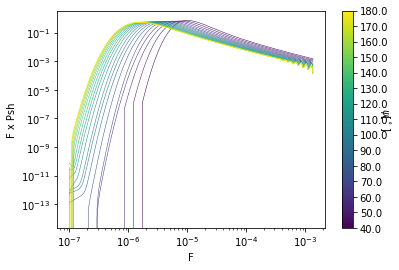

In [6]:
numnum = 20
psis = np.linspace(40, 180, num=numnum)
colors = cm.viridis(np.linspace(0, 1, num=numnum))

fig, ax = plt.subplots()

psh_vals_over_psi = []
fxs = fluxes
for psi, col in zip(psis, colors):
    ax.plot(fxs, fxs * pshfunc2d(psi, fxs).flatten(), label=rf"{psi}$^\circ$", color=col, lw=0.5)
#     print(np.trapz(fxs * pshfunc2d(psi, fxs).flatten(), fxs))
   
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('F')
ax.set_ylabel('F x Psh')
cbarlabs = np.arange(min(psis), max(psis)+1, step=10)
cbar = fig.colorbar(cm.ScalarMappable(cmap=cm.viridis), ticks=np.linspace(0, 1, num=len(cbarlabs)))
cbar.set_label(r'$\psi$[$^\circ$]', rotation=270)
cbar.ax.set_yticklabels(cbarlabs);

In [7]:
pshfunc2d(psis, fluxes).shape, psis.shape, fluxes.shape

((195, 20), (20,), (195,))

In [8]:
for psi in psis:
    minn = pshfunc2d(psi, fluxes).argmin()
    print(psi, pshfunc2d(psi, fluxes)[minn])

40.0 [0.]
47.368421052631575 [0.]
54.73684210526316 [0.]
62.10526315789474 [-2.40612127e-07]
69.47368421052632 [-1.08275457e-06]
76.84210526315789 [-1.35459412e-06]
84.21052631578948 [1.24189836e-06]
91.57894736842105 [6.06540398e-06]
98.94736842105263 [1.03529737e-05]
106.3157894736842 [4.82912706e-06]
113.68421052631578 [6.59501744e-05]
121.05263157894737 [0.00024274]
128.42105263157896 [0.00040166]
135.78947368421052 [-0.0001204]
143.1578947368421 [-0.00176458]
150.5263157894737 [-0.00507399]
157.89473684210526 [-0.00980803]
165.26315789473682 [-0.01309698]
172.6315789473684 [-0.01504543]
180.0 [-0.01562145]


In [9]:
counts = np.arange(0, 20)
exposure = 1 * 14000 * 0.2/0.5
psi = 40

In [10]:
from scipy.stats import poisson
print(poisson.pmf(counts[:, np.newaxis], exposure * fluxes).shape, pshfunc2d(40, fluxes).flatten().shape)

pcvals = np.trapz(pshfunc2d(psi, fluxes).flatten() * poisson.pmf(counts[:, np.newaxis], exposure * fluxes), fluxes, axis=-1)
# func = pshfunc2d(40, fluxes).flatten() * poisson.pmf(2, exposure * fluxes)
pcvals

(20, 195) (195,)


array([9.02205235e-01, 8.30880381e-02, 9.19468437e-03, 2.34458514e-03,
       1.03947659e-03, 5.74242838e-04, 3.45789201e-04, 2.13448904e-04,
       1.30500824e-04, 7.74383053e-05, 4.40763354e-05, 2.39086045e-05,
       1.23205500e-05, 6.02481788e-06, 2.79602611e-06, 1.23249305e-06,
       5.16675059e-07, 2.06291374e-07, 7.85707020e-08, 2.85926260e-08])

In [11]:
print(exposure*np.trapz(fluxes * pshfunc2d(40, fluxes).flatten(), fluxes))
pp = poisson.pmf(counts, exposure*np.trapz(fluxes * pshfunc2d(40, fluxes).flatten(), fluxes))

0.1218517051804078


Text(0, 0.5, 'P(C) for 40 deg, n=0')

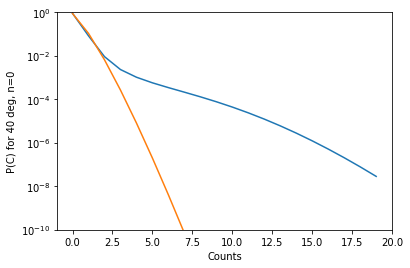

In [12]:
plt.plot(counts, pcvals)
plt.plot(counts, pp)
ax = plt.gca()

ax.set_yscale('log')
ax.set_ylim(top=1, bottom=1e-10)
ax.set_xlim(right=20)
ax.set_xlabel('Counts')
ax.set_ylabel('P(C) for 40 deg, n=0')

In [13]:
import healpy

In [14]:
nside = p['nside']
npix = healpy.nside2npix(nside)
pixel_counts = np.ones(npix) * healpy.pixelfunc.UNSEEN
print(npix)

196608


In [15]:
lon, lat = healpy.pix2ang(nside, range(npix), lonlat=True)
ang_dists = np.rad2deg(np.arccos(np.cos(np.deg2rad(lon)) * np.cos(np.deg2rad(lat))))
ang_dists, lon, lat

(array([89.74156502, 90.25843498, 90.25843498, ..., 90.25843498,
        90.25843498, 89.74156502]),
 array([ 45., 135., 225., ..., 135., 225., 315.]),
 array([ 89.6345165,  89.6345165,  89.6345165, ..., -89.6345165,
        -89.6345165, -89.6345165]))

In [16]:
lon, lat, max(ang_dists), min(ang_dists)

(array([ 45., 135., 225., ..., 135., 225., 315.]),
 array([ 89.6345165,  89.6345165,  89.6345165, ..., -89.6345165,
        -89.6345165, -89.6345165]),
 179.70158313251247,
 0.2984168674875423)

In [17]:
print(healpy.nside2pixarea(128, degrees=True))

0.2098234113027917


In [18]:
psis = np.linspace(40, 180, num=50)
pc_psi = np.array([np.trapz(pshfunc2d(abs(psi), fluxes).flatten() * poisson.pmf(counts[:, np.newaxis], exposure * fluxes), fluxes, axis=-1) for psi in psis])
pc_of_psi = intp.interp1d(psis, pc_psi, axis=0)

In [19]:
good_indices = (abs(lat) >= 40)
subsample = ang_dists[good_indices]
print(len(subsample))
sub_counts = np.zeros(len(subsample))
for i, psi in enumerate(subsample):
    if i % 10000 == 0:
        print(i, '/', len(subsample))
#     print(psi)
    pcvals = pc_of_psi(abs(psi))
    sub_counts[i] = np.random.choice(np.arange(len(pcvals)), size=1, p=pcvals/np.sum(pcvals))
    
pixel_counts[good_indices] = sub_counts
pixel_counts_pc = pixel_counts[:]

70144
0 / 70144
10000 / 70144
20000 / 70144
30000 / 70144
40000 / 70144
50000 / 70144
60000 / 70144
70000 / 70144


In [20]:
np.sum(pixel_counts > 0)

3264

0.8392936452111668


(0.05748175182481752, 4032.0)

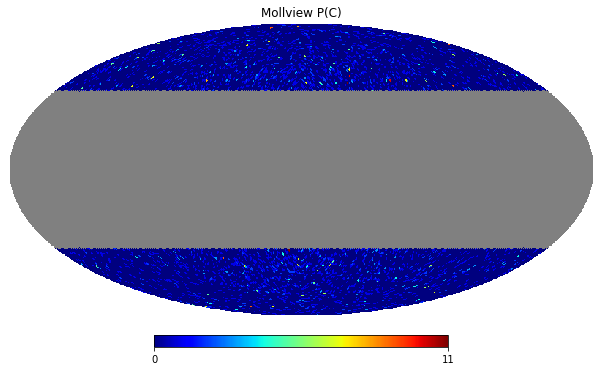

In [21]:
nreduce = 64
healpy.mollview(healpy.pixelfunc.ud_grade(healpy.pixelfunc.ma(pixel_counts_pc), nreduce, pess=True, power=-2), cmap=cm.jet, title="Mollview P(C)")
print(healpy.nside2pixarea(nreduce, degrees=True))
np.mean(pixel_counts_pc[good_indices]), np.sum(pixel_counts_pc[good_indices])

In [22]:
lsub = len(subsample)
pixel_counts_poisson = np.ones(npix) * healpy.pixelfunc.UNSEEN
sub_counts = np.zeros(lsub)
for i, psi in enumerate(subsample):
    if i % 100000 == 0:
        print(i, '/', lsub)
#     print(psi)
    sub_counts[i] = stats.poisson.rvs(exposure*np.trapz(fluxes * pshfunc2d(psi, fluxes).flatten(), fluxes))
    if sub_counts[i] > 5: 
        print(sub_counts[i])
    
pixel_counts_poisson[good_indices] = sub_counts


0 / 70144


(0.055713959854014596, 3908.0)

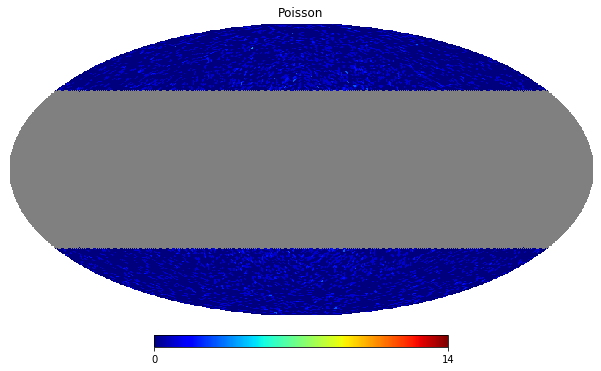

In [23]:
healpy.mollview(healpy.pixelfunc.ud_grade(healpy.pixelfunc.ma(pixel_counts_poisson), nreduce, pess=True, power=-2), cmap=cm.jet, title="Poisson", max=14)
np.mean(pixel_counts_poisson[good_indices]), np.sum(pixel_counts_poisson[good_indices])

In [24]:
with np.load('./output/n0_pshfunc.npz') as f:
    psi = f['psi']
    fluxes = f['flux']
    psh2d = f['psh']

# restrict to valid range of flux calculation
valid_lim = -55
fluxes = fluxes[:valid_lim]
psh2d = psh2d[:valid_lim]

# generate data with different fwimp
f = 10
# fluxes *= f
# psh2d /= f

# get psh data as function of psi and flux
counts = np.arange(0, 20)
psh2d[psh2d < 0] = 0
pshfunc2d = intp.interp2d(psi, fluxes, np.nan_to_num(psh2d), bounds_error=False, fill_value=0)

# make the simulated skymap
psis = np.linspace(40, 180, num=50)
pc_psi = np.array([np.trapz(1/f * pshfunc2d(abs(psi), fluxes).flatten() * stats.poisson.pmf(counts[:, np.newaxis], p['exposure'] * f * fluxes), f * fluxes, axis=-1) for psi in psis])
pc_of_psi = intp.interp1d(psis, pc_psi, axis=0)

subcounts, ang_dists = pd.generate_skymap_sample_pc(p, pc_of_psi, return_subcounts=True, save_output=True)

# get psh for the angles we are considering 
psh = pshfunc2d(np.abs(ang_dists), fluxes)
psh /= np.trapz(psh, fluxes, axis=0)
# print(ang_dists.shape)

saved in ./output/n0_skymap_51768.npy


In [ ]:
importlib.reload(pd)
import time
start_time = time.time()
num_search = 50
fwimp_search = (np.log10(f)-2, np.log10(f)+1, num_search)

# backgrounds
gal_bg = np.load(p['gal_flux_bg_file'])[good_indices] * p['exposure']
iso_bg = p['iso_flux_bg'] * p['exposure']
bg_count = gal_bg + iso_bg

counts = np.arange(0, 150)

S, fwimps = pd.likelihood(p, psh, subcounts.astype(np.int16), fluxes, counts, fwimp_limits=fwimp_search, bg_count=bg_count)

print('time per eval', (time.time() - start_time)/num_search)

0 / 50


In [ ]:
S

In [ ]:
fig, axs = plt.subplots()
axs.plot(fwimps, -(S - S.min()), color='xkcd:tangerine', label='P(C)')
axs.set_xlabel(r'f$_{SUSY}$', fontsize=20)
axs.set_xscale('log')
axs.set_ylabel(r'$\mathcal{L}$', fontsize=20)
print(fwimps[S.argmin()], S.min())
print('max L:', np.exp(-0.5*S.min()))

In [ ]:
importlib.reload(pd)
Spoi, fwimpspoi = pd.poisson_likelihood(p, psh, subcounts.astype(np.int16), fluxes, counts, fwimp_limits=fwimp_search)

In [ ]:
axs.plot(fwimpspoi, (-(Spoi-Spoi.min())), color='xkcd:wine', label='Poisson')
axs.legend()
axs.set_yscale('linear')
print('P(C) min of -2 ln L:', S.min())
print('Poisson min of -2 ln L:', Spoi.min())
fig

In [ ]:
print(fwimps[Spoi.argmin()], Spoi.min())
print(np.log10(np.e)*1500)

In [ ]:
from astropy.io import fits
bg = fits.open('output/background.fits')

In [ ]:
bg[0].header

In [ ]:
a = np.reshape(np.arange(9), (3, 3))
print(a)
a[np.array([[1, 0], [1, 2] , [2, 1]])]

In [ ]:
import scipy.stats as st

class my_pdf(st.rv_continuous):
    def _pdf(self, x):
        return custom_pdf(x)
    
    def _cdf(self, x):
        return custom_cdf(x)
    
    def _ppf(self, x):
        return custom_ppf(x)

In [ ]:
psi = 50
custom_pdf = lambda x: pshfunc2d(psi, x).flatten()

norm = np.trapz(pshfunc2d(psi, fluxes).flatten(), fluxes)
discrete_cdf = integrate.cumtrapz(pshfunc2d(psi, fluxes).flatten(), fluxes, initial=0)
custom_cdf = intp.interp1d(fluxes, discrete_cdf, fill_value=0, bounds_error=False)

custom_ppf = intp.interp1d(discrete_cdf, fluxes, fill_value=0, bounds_error=False)

func50 = my_pdf(a=fluxes.min(), b=fluxes.max(), name='my_pdf')

In [ ]:
# pcvals = np.trapz(pshfunc2d(psi, fluxes).flatten() * poisson.pmf(counts[:, np.newaxis], exposure * fluxes), fluxes, axis=-1)

def pc(psi, counts_max=15):
    counts = np.arange(0, counts_max + 1)
    
    pcvals = np.trapz(pshfunc2d(psi, fluxes).flatten() * poisson.pmf(counts[:, np.newaxis], exposure * fluxes), fluxes, axis=-1)
    custom_pdf = intp.interp1d(counts, pcvals, fill_value=0, bounds_error=False)
    
    discrete_cdf = integrate.cumtrapz(pcvals, counts, initial=0)
    custom_cdf = intp.interp1d(counts, discrete_cdf, fill_value=0, bounds_error=False)

    custom_ppf = intp.interp1d(discrete_cdf, counts, fill_value=0, bounds_error=False)
    
    return my_pdf(a=fluxes.min(), b=fluxes.max(), name='my_pdf')

In [ ]:
pc(50).rvs(size=10)

In [ ]:
psi = 40
pcvals = np.trapz(pshfunc2d(psi, fluxes).flatten() * poisson.pmf(counts[:, np.newaxis], exposure * fluxes), fluxes, axis=-1)
pp = poisson.pmf(counts, exposure*fluxes[np.argmax(pshfunc2d(psi, fluxes))])

print(np.sum(pcvals/np.sum(pcvals)))
plt.plot(counts, pcvals)
plt.plot(counts, pp)
plt.hist(np.random.choice(np.arange(len(pcvals)), size=100000, p=pcvals/np.sum(pcvals)))

ax = plt.gca()
ax.set_yscale('log')
# ax.set_ylim(top=1, bottom=1e-20)
ax.set_xlabel('Counts')
# ax.set_xscale('log')
ax.set_ylabel('P(C) for 40 deg, n=0')

In [ ]:
fig, ax = plt.subplots()
bins = np.logspace(np.log10(fluxes.min()), np.log10(fluxes.max()), num=50)
ax.hist(func50.rvs(size=100000), bins=bins)
ax.plot(fxs, fxs * pshfunc2d(psi, fxs).flatten(), label=rf"{psi}$^\circ$")
ax.set_xscale('log')
ax.set_yscale('log')

In [ ]:
for i, latt in enumerate(lat):
    if latt < 40:
        pixel_counts[i] = 0
    else:
        